<a href="https://colab.research.google.com/github/fambargh/evaluate/blob/master/just_for_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from zipfile import ZipFile
filename = "im.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

In [ ]:
!pip install tensorflow==2.2.0

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


In [ ]:
# Install required libs

!pip install -U --pre segmentation-models --user

In [3]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
x_train_dir = '/content/image_train/'
y_train_dir = '/content/a1_cup_train/'

x_valid_dir = '/content/image_valid/'
y_valid_dir = '/content/a1_cup_valid'

x_test_dir = '/content/im/female/'
y_test_dir = '/content/gt_cod/female/g_cup/'

In [5]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """ Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'oc','nolabeled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. oc)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

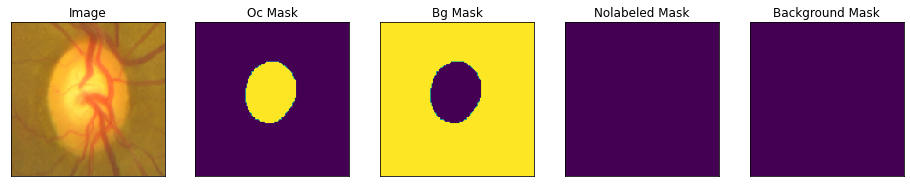

In [6]:
# Lets look at data we have
dataset = Dataset(x_test_dir, y_test_dir, classes=['oc','bg','nolabeled'])
image, mask = dataset[20] # get some sample
#cv2.imwrite('/content/result/0.png',image)
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    bg_mask=mask[..., 1].squeeze(),
    nolabeled_mask=mask[..., 2].squeeze(),
    background_mask=mask[..., 3].squeeze(),
    )

In [6]:
import albumentations as A


In [7]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        A.RandomCrop(height=128, width=128, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=20, p=1),
                A.MotionBlur(blur_limit=20, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(128, 128)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

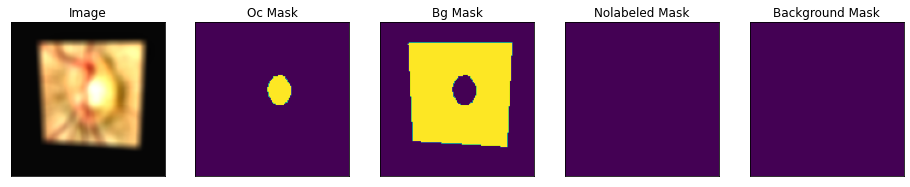

In [9]:
# Lets look at augmented data we have
dataset = Dataset(x_test_dir, y_test_dir, classes=['oc', 'bg','nolabeled'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    bg_mask=mask[..., 1].squeeze(),
    nolabeled_mask=mask[..., 2].squeeze(),
    background_mask=mask[..., 3].squeeze(),
)

In [8]:
%env SM_FRAMEWORK=tf.keras



env: SM_FRAMEWORK=tf.keras


In [ ]:
import segmentation_models as sm


In [12]:
BACKBONE = 'seresnet50'
BATCH_SIZE = 2
CLASSES = ['oc']
#LR = 0.0001
EPOCHS = 200

preprocess_input = sm.get_preprocessing(BACKBONE)

In [13]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [14]:
# define optomizer
optim = keras.optimizers.RMSprop(lr=0.0001)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(), sm.metrics.Recall()]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [15]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [16]:
# load best weights from chosen model
model.load_weights('best_model_disc2.h5')

In [ ]:
##executing time=1.382s
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

image1prime.png
(128, 128)


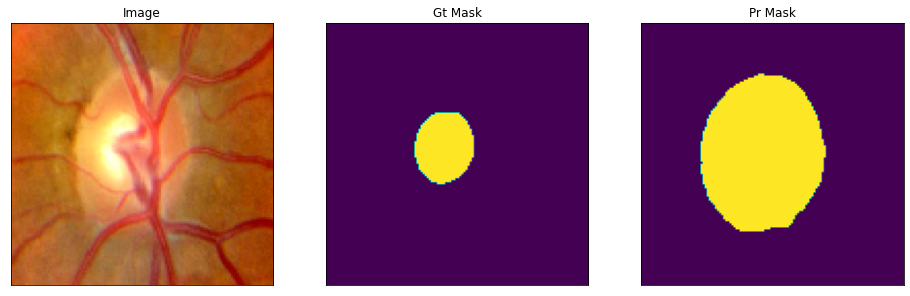

image31prime.png
(128, 128)


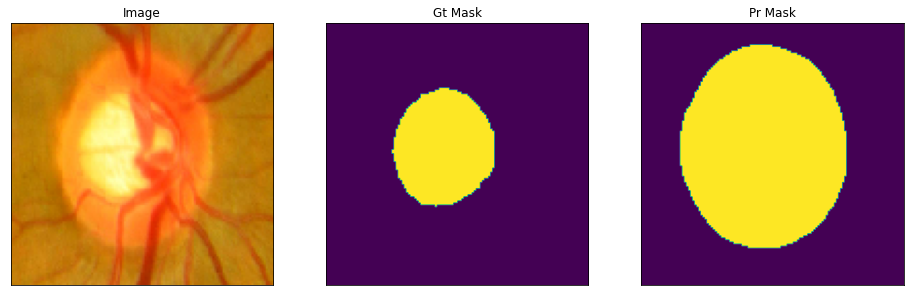

image7prime.png
(128, 128)


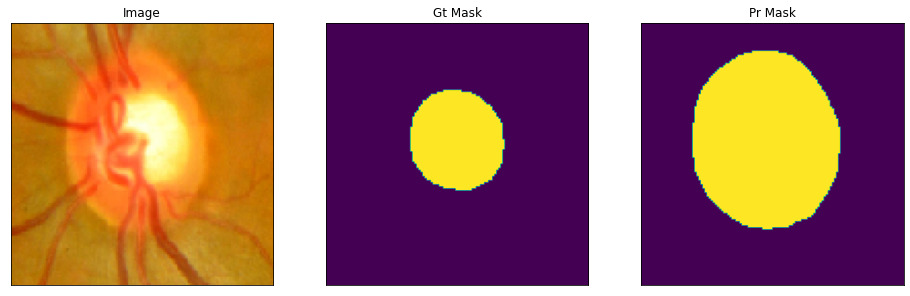

image43prime.png
(128, 128)


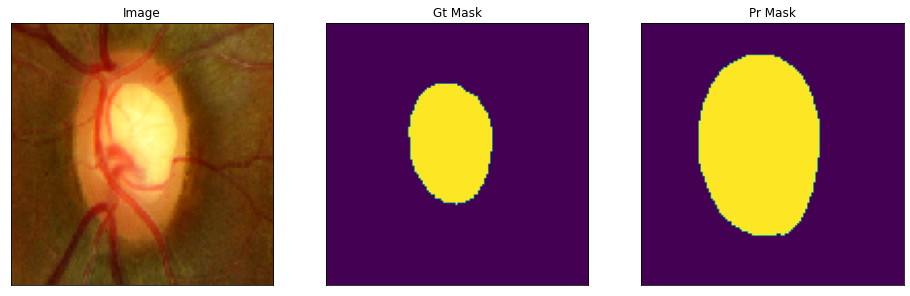

image39prime.png
(128, 128)


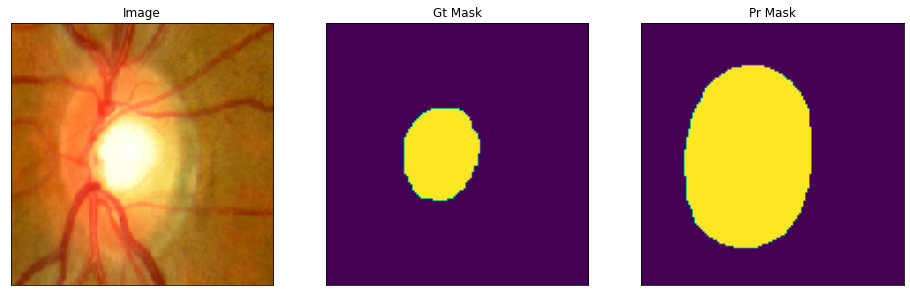

image45prime.png
(128, 128)


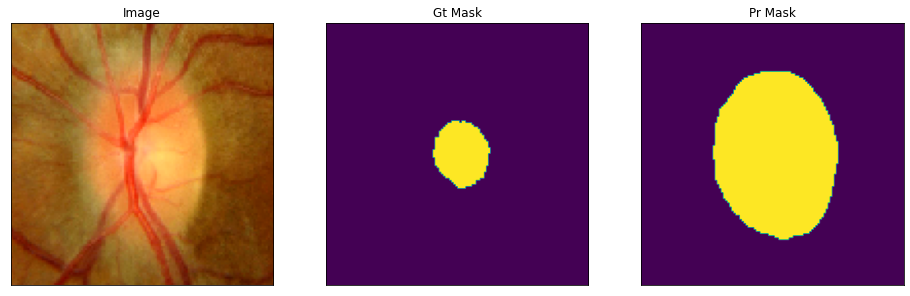

image4prime.png
(128, 128)


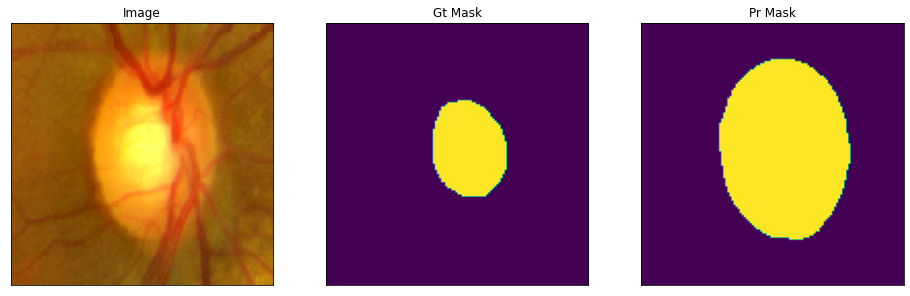

image22prime.png
(128, 128)


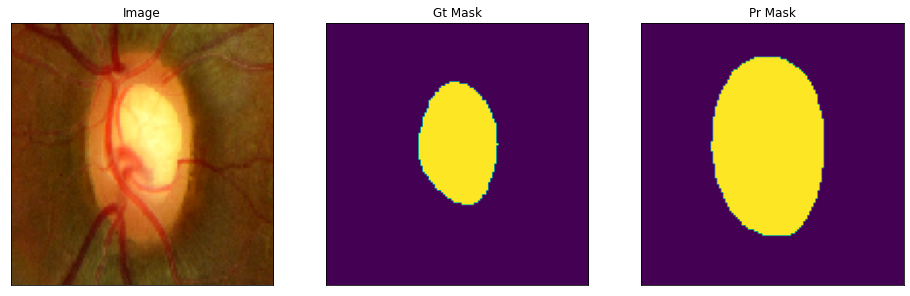

image40prime.png
(128, 128)


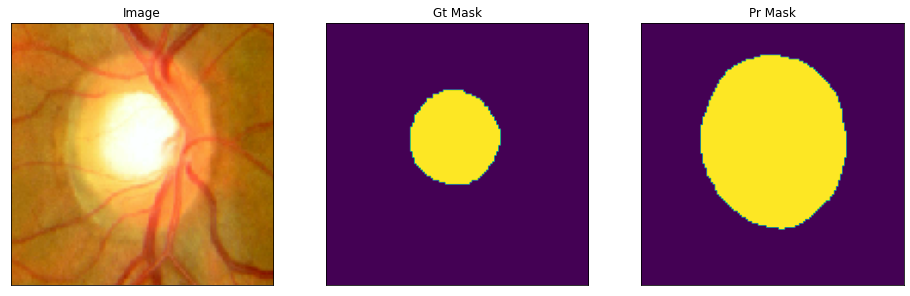

image42prime.png
(128, 128)


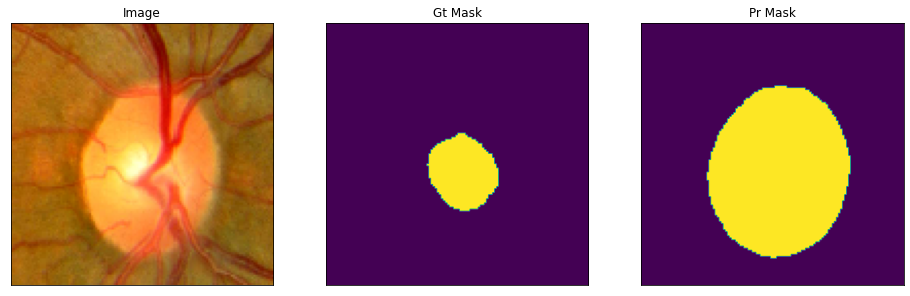

image17prime.png
(128, 128)


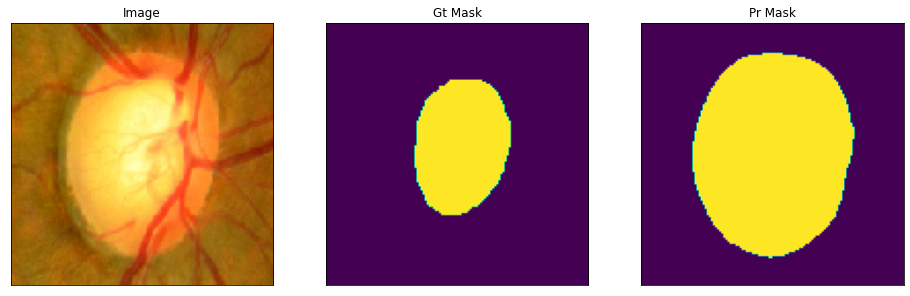

image15prime.png
(128, 128)


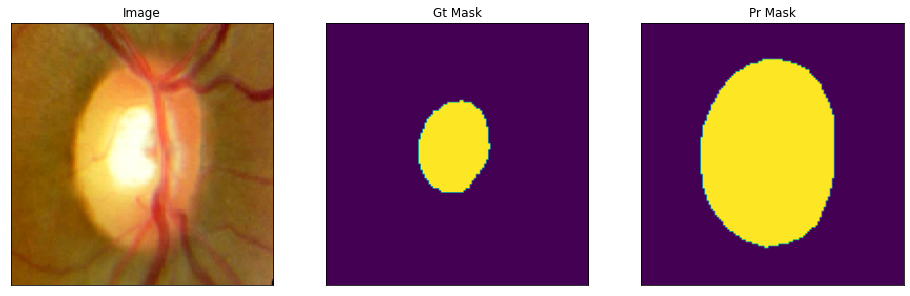

image16prime.png
(128, 128)


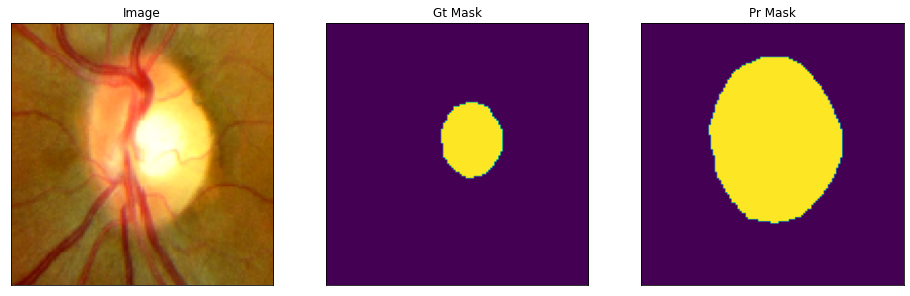

image25prime.png
(128, 128)


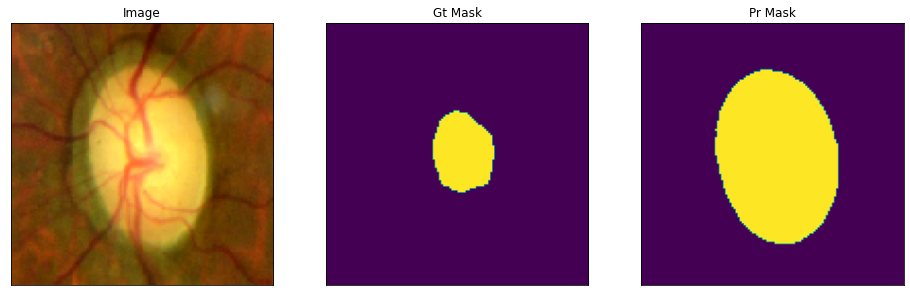

image27prime.png
(128, 128)


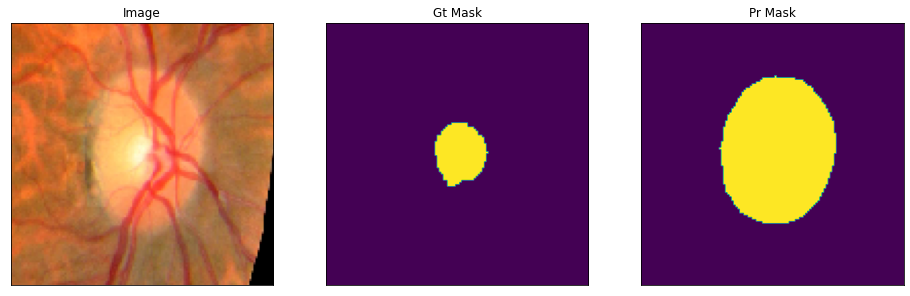

image36prime.png
(128, 128)


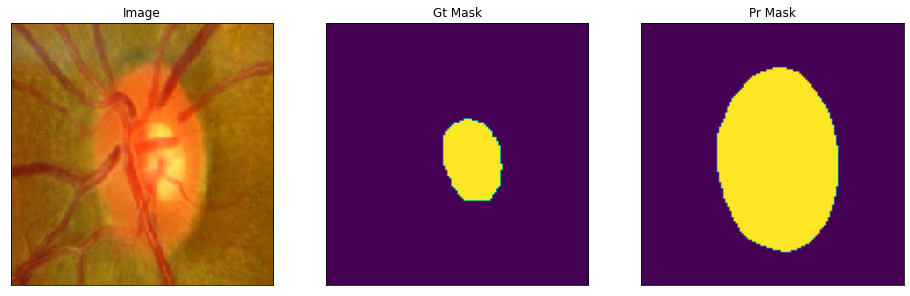

image35prime.png
(128, 128)


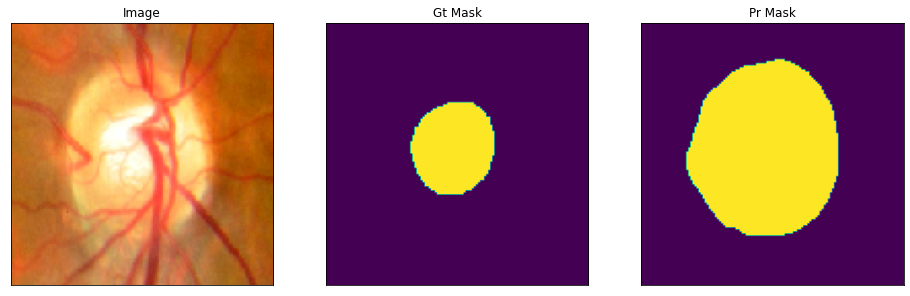

image12prime.png
(128, 128)


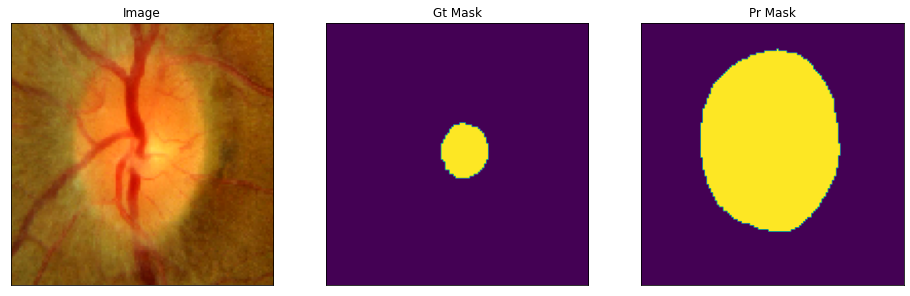

image2prime.png
(128, 128)


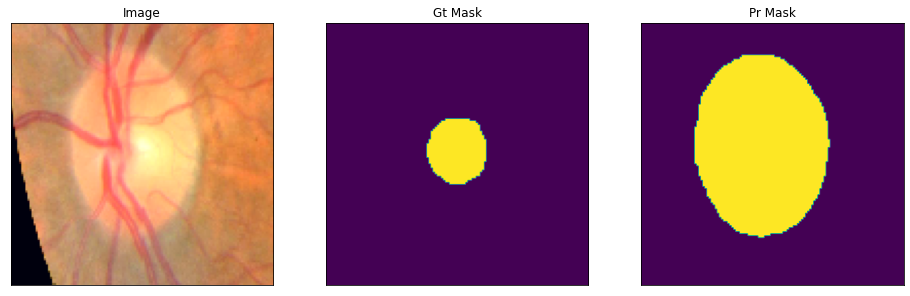

image18prime.png
(128, 128)


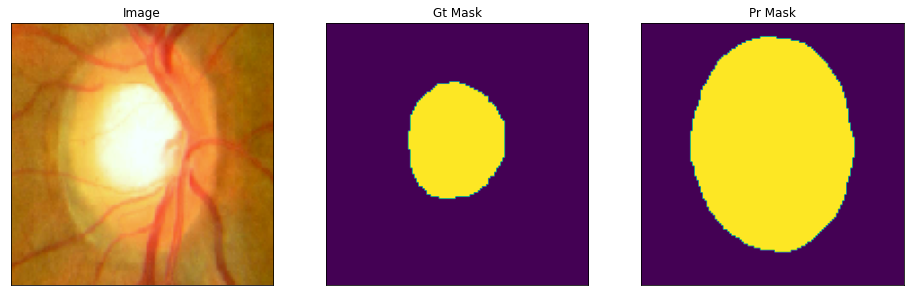

image10prime.png
(128, 128)


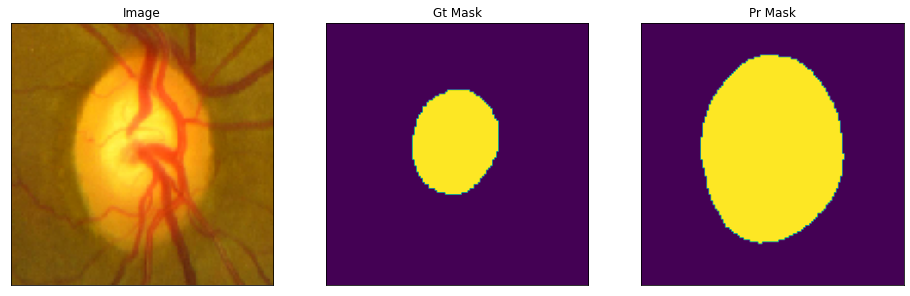

image30prime.png
(128, 128)


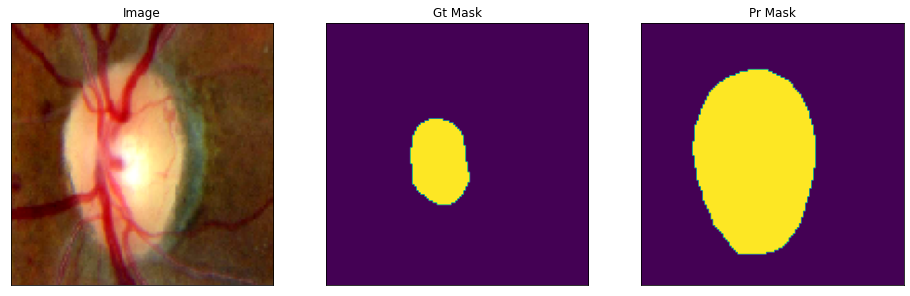

image29prime.png
(128, 128)


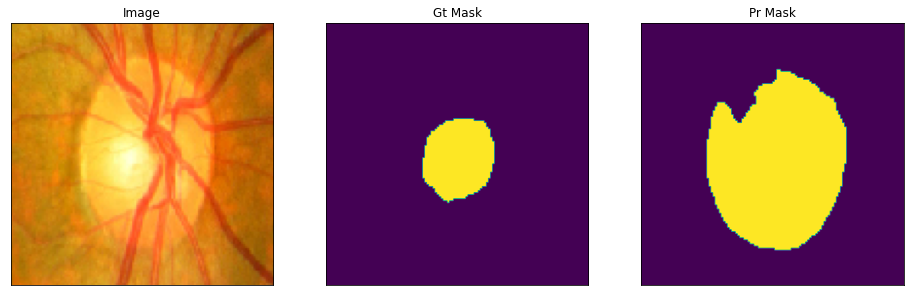

image6prime.png
(128, 128)


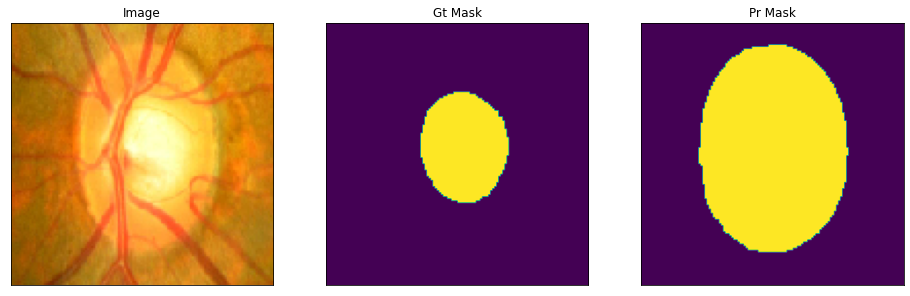

image38prime.png
(128, 128)


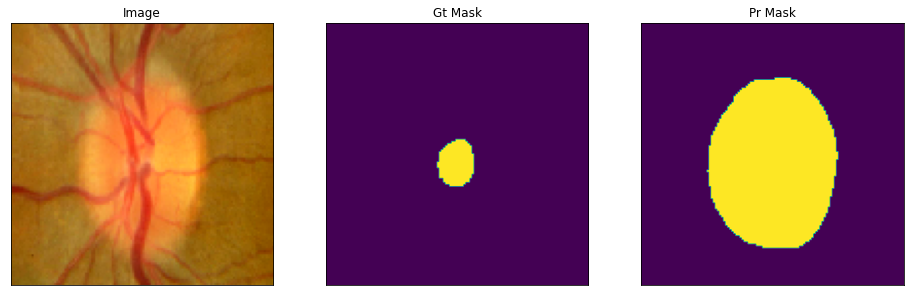

image5prime.png
(128, 128)


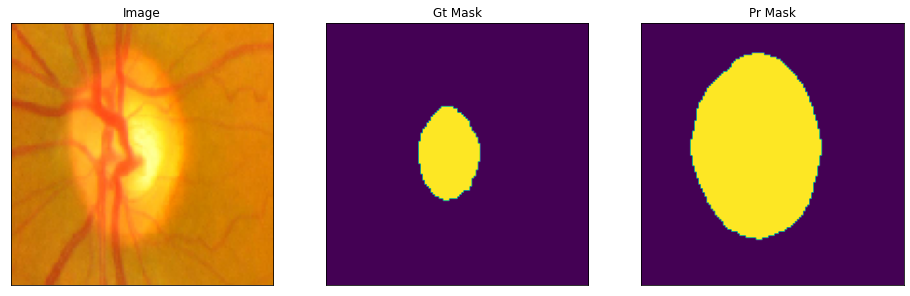

image21prime.png
(128, 128)


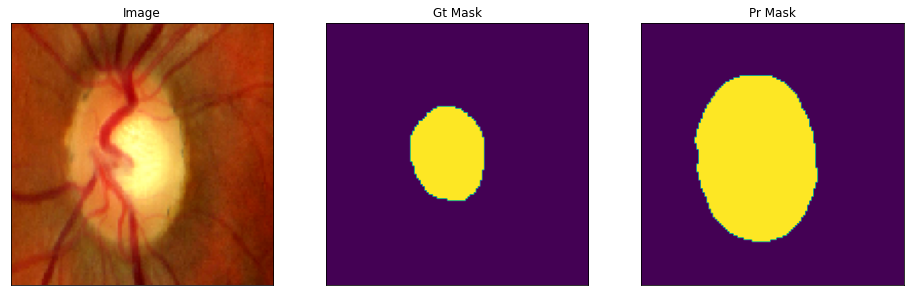

image28prime.png
(128, 128)


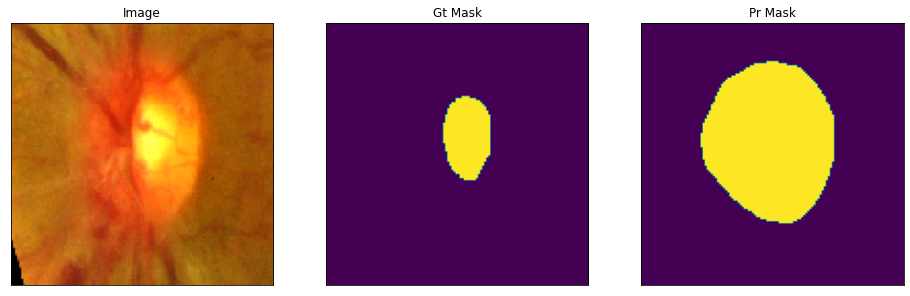

image13prime.png
(128, 128)


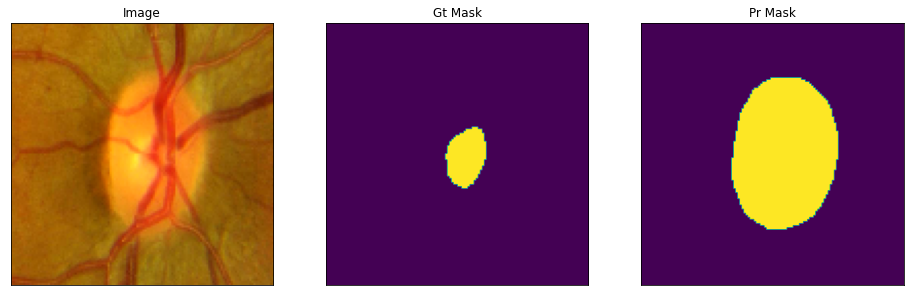

image23prime.png
(128, 128)


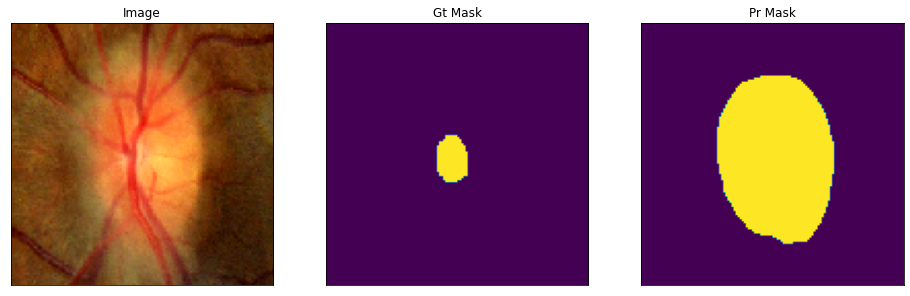

image3prime.png
(128, 128)


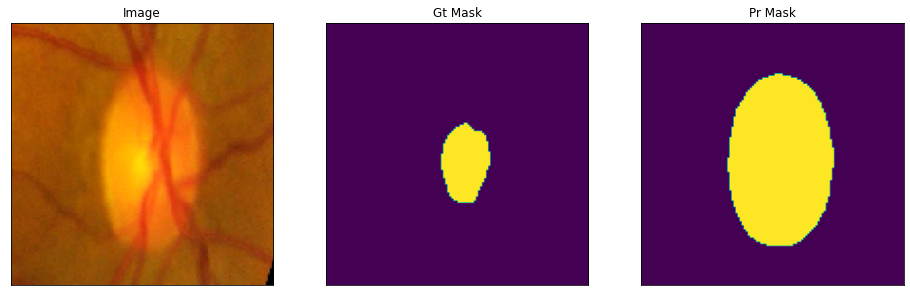

image11prime.png
(128, 128)


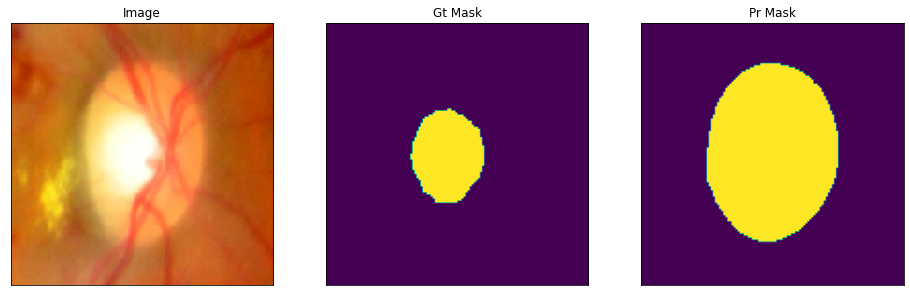

image33prime.png
(128, 128)


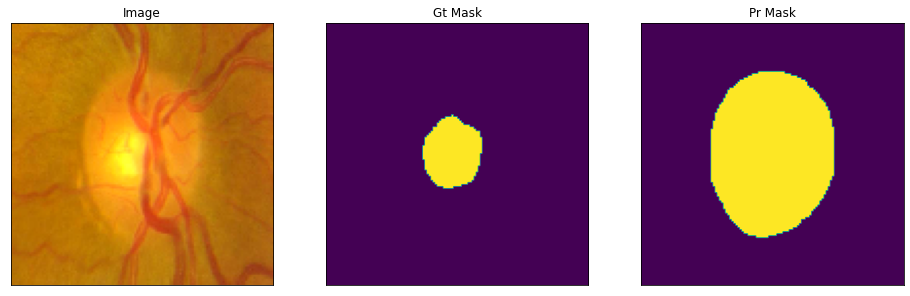

image9prime.png
(128, 128)


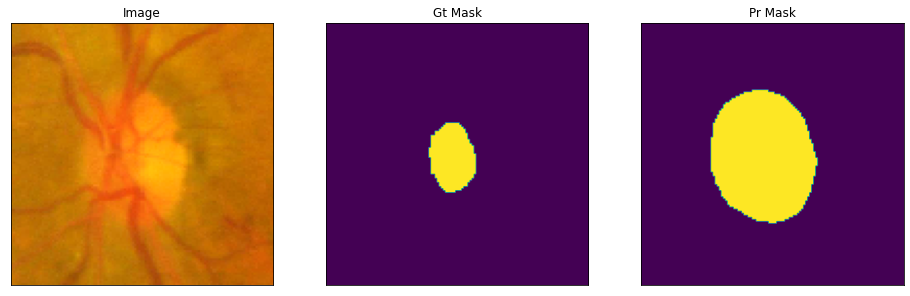

image8prime.png
(128, 128)


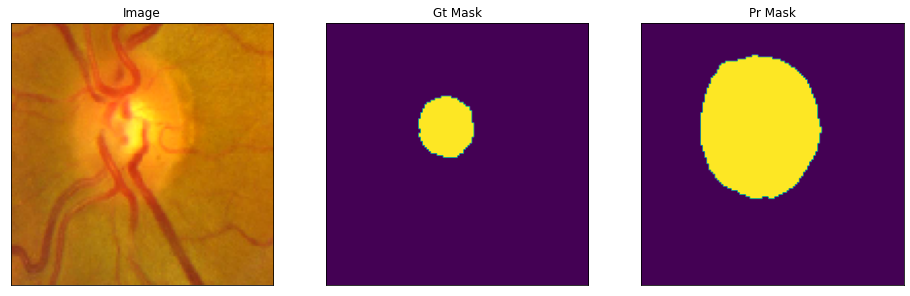

image32prime.png
(128, 128)


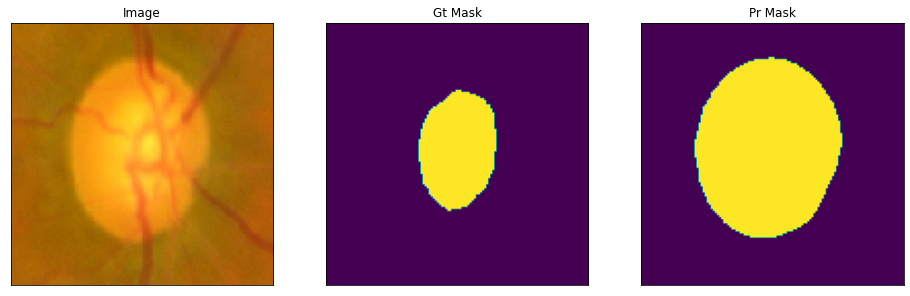

image37prime.png
(128, 128)


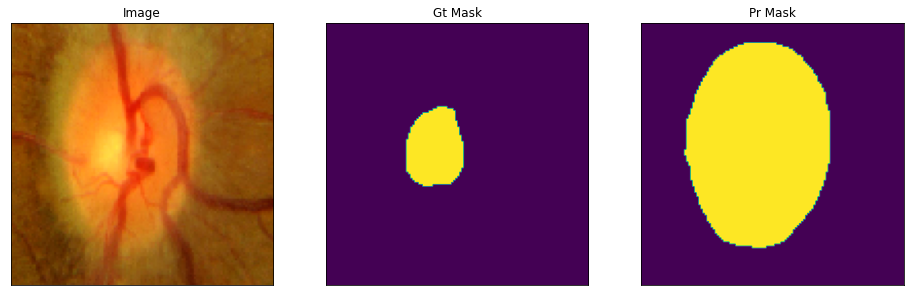

image41prime.png
(128, 128)


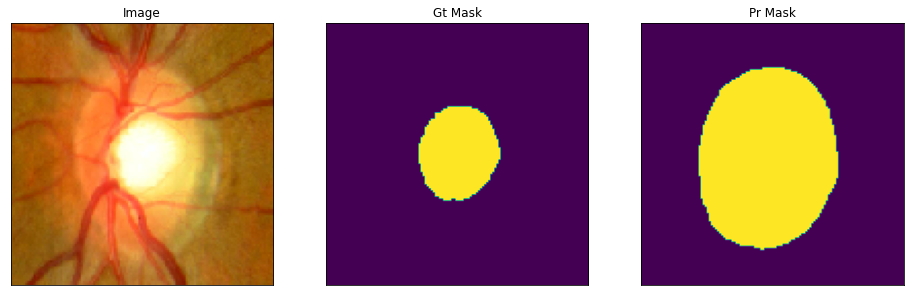

image20prime.png
(128, 128)


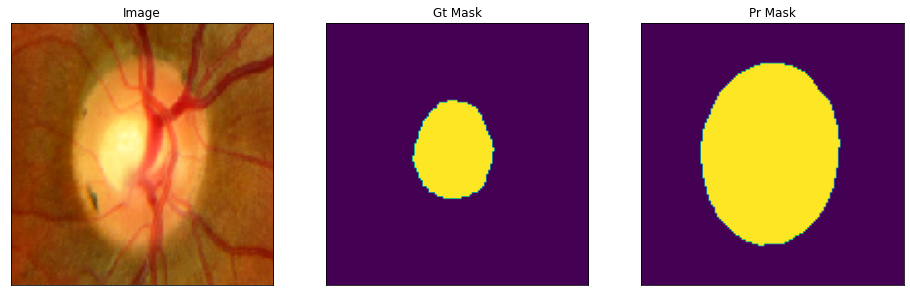

image44prime.png
(128, 128)


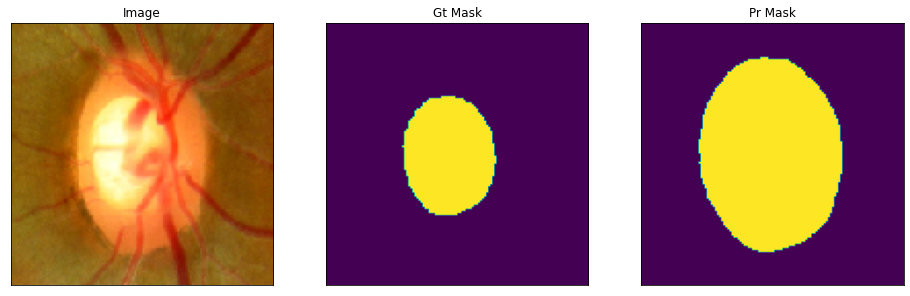

image34prime.png
(128, 128)


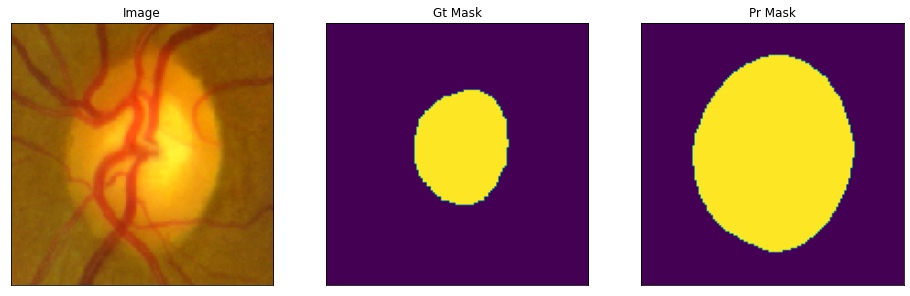

image14prime.png
(128, 128)


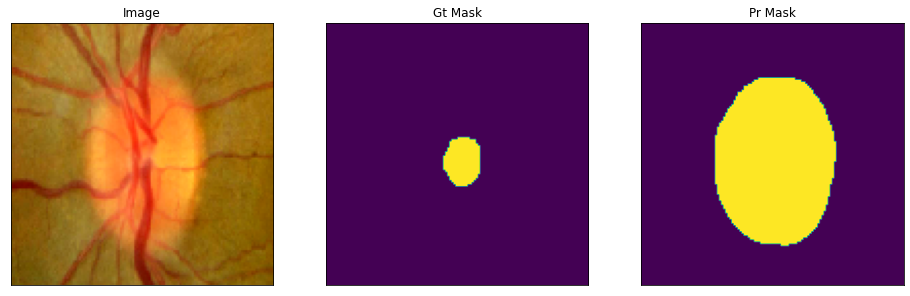

image26prime.png
(128, 128)


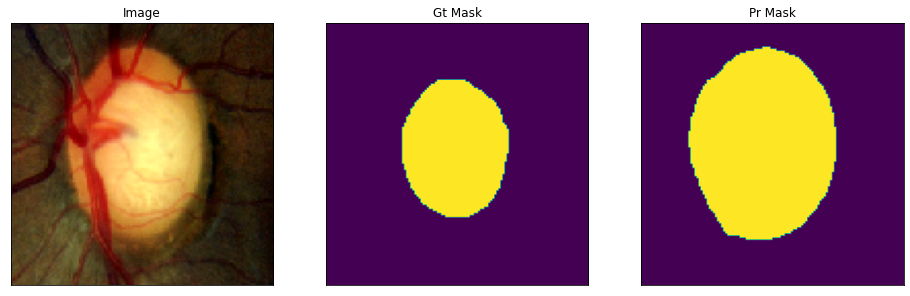

image24prime.png
(128, 128)


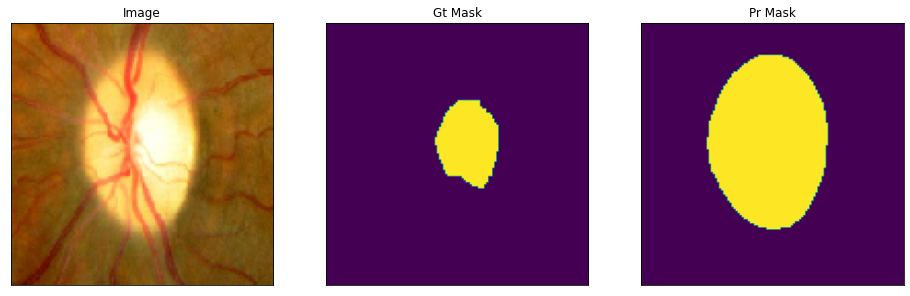

image46prime.png
(128, 128)


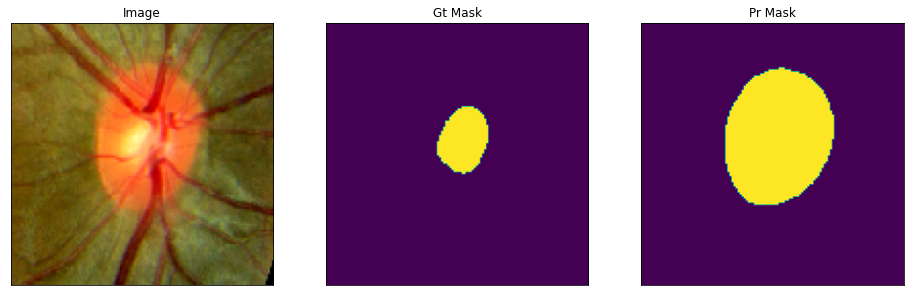

image19prime.png
(128, 128)


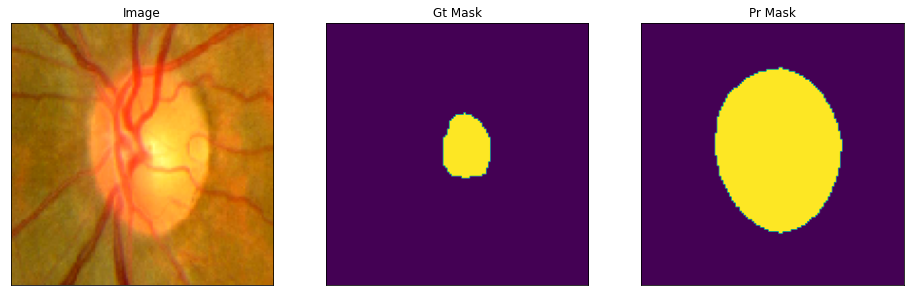

image47prime.png
(128, 128)


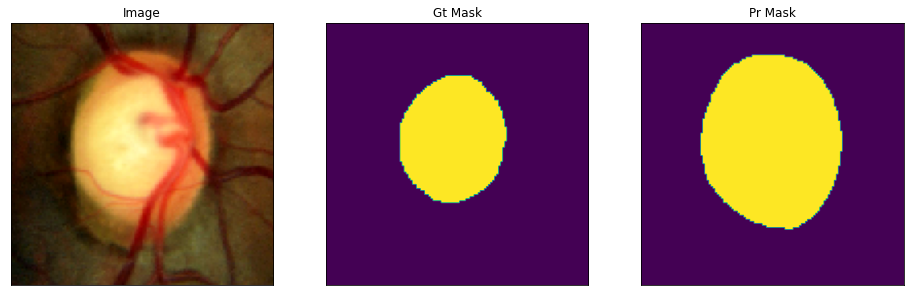

In [18]:
#first make your folder
ids = os.listdir(x_test_dir)
images_fps1 = [os.path.join(x_test_dir, image_id) for image_id in ids]

import numpy
for i in range(len(images_fps1)):
  ids = os.listdir(x_test_dir)
  image, gt_mask = test_dataset[i]
  print(ids[i])
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()
  out_arr = numpy.squeeze(pr_mask)  
  cv2.imwrite('/content/result7/{}'.format(ids[i]),out_arr)
  print(out_arr.shape)
  visualize(
      image=denormalize(image.squeeze()),
      gt_mask=gt_mask[..., 0].squeeze(),
      pr_mask=pr_mask[..., 0].squeeze(),
      )  


In [ ]:
!zip -r /content/disc2_female.zip /content/result7

In [ ]:
for idx, img_name in enumerate(sorted(os.listdir(x_test_dir))):
  print(img_name)